# GOAL
1. Create a score for each article based on engagement, sentiment, richness, and quality.
2. Use the score to find the highest quality articles.
3. Analyze the features of the highest quality articles.
4. Determine which features are most important for creating a high quality article.



## Approach

1. Choose a set of features to use.
2. Weight each feature so that the sum of the weights equals 1.0 (or 100%).
3. Create a function to normalize the values of each feature to a scale of 1-10. Add a square root transformation to help spread out the scores more evenly so they're not all clustered in the middle.
4. Once each feature is normalized, multiply it by its weight and sum the values for each article.
5. For example, if an article has 1000 shares, 15 links, 2 images, 0 videos, a sentiment of 0.5, a positivity rate of 0.3, an average positive polarity of 0.2, 1000 words, an average token length of 5, and 0 self links, its score would be calculated as follows:
    shares: 1000 * 0.25 = 250
    links: 15 * 0.15 = 2.25
    images: 2 * 0.10 = 0.20
    videos: 0 * 0.10 = 0.00
    sentiment: 0.5 * 0.10 = 0.05
    positivity: 0.3 * 0.10 = 0.03
    positive polarity: 0.2 * 0.05 = 0.01
    words: 1000 * 0.05 = 50
    token length: 5 * 0.05 = 0.25
    self links: 0 * 0.05 = 0.00
    Total score: 250 + 2.25 + 0.20 + 0.00 + 0.05 + 0.03 + 0.01 + 50 + 0.25 + 0.00 = 307.74
6. Rescale the final scores to ensure they use the 1-10 scale.
7. For example, using the example above, the final score would be 7.7. The math from the function is:
    (307.74 - 1) / (10 - 1) * 9 + 1 = 7.7
8. A score of 10 represents articles that perform best across all weighted metrics.
9. A score of 1 represents articles that perform worst across all weighted metrics.
10. Most articles will fall somewhere in the middle.



### Import libraries

In [1]:
# Core libraries
import pandas as pd
import requests
import zipfile
import io
import os
from scipy import stats

# Panda settings
pd.set_option('display.max_columns', None)

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns

### Download and extract the data

#### Dataset background

The dataset contains 39,797 news articles published by Mashable between January 2013 and December 2016.

More information about the dataset can be found here: https://archive.ics.uci.edu/dataset/332/online+news+popularity

For details on the features, see the dataset description here: https://archive.ics.uci.edu/dataset/332/online+news+popularity/view


In [2]:
# URL of the file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip"

# Make sure the data folder exists
os.makedirs("webdata/data", exist_ok=True)

# Download the file
response = requests.get(url)

# Check if the download was successful
if response.status_code == 200:
    # Use BytesIO to read the content as a file-like object
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Extract all files to the "data" folder
        z.extractall("webdata/data")
    print("Download and extraction complete.")
else:
    print("Failed to download the file.")


Download and extraction complete.


### Inspect the data

In [3]:
df = pd.read_csv('webdata/data/OnlineNewsPopularity/OnlineNewsPopularity.csv')


In [4]:
df.shape

(39644, 61)

In [5]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


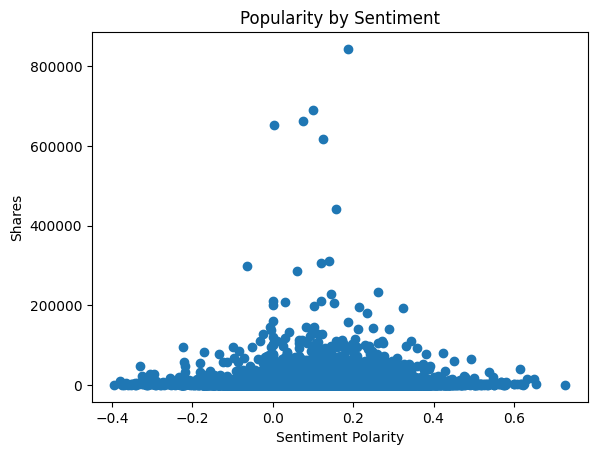

In [6]:
# Plot the relationship between sentiment and shares

from matplotlib import pyplot as plt
plt.scatter(df[' global_sentiment_polarity'],df[' shares'])
plt.title('Popularity by Sentiment')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Shares')
plt.show()

### Create a health score for each article using key features



Pick the features to use and weight them. At this point, we are manually selecting the features and weights.

The weights are defined in a dictionary for clarity and ease of modification. The weights sum to 1.0 (or 100%).

In [7]:
feature_weights = {
    ' shares': 0.25,              # Highest weight - engagement
    ' num_hrefs': 0.15,          # Strong weight - indicates engagement
    ' num_imgs': 0.10,           # Medium weight - content richness
    ' num_videos': 0.10,         # Medium weight - content richness
    ' global_sentiment_polarity': 0.10,  # Medium weight - sentiment
    ' global_rate_positive_words': 0.10, # Medium weight - sentiment
    ' avg_positive_polarity': 0.05,      # Lower weight - supplementary sentiment
    ' n_tokens_content': 0.05,    # Lower weight - article length
    ' average_token_length': 0.05,# Lower weight - writing complexity
    ' num_self_hrefs': 0.05      # Lower weight - internal links
}

In [8]:
# Define the features we want to use for scoring
score_features = list(feature_weights.keys())  # Use the keys from our weights dictionary

In [14]:
print("NaN values in features:")
print(df[score_features].isna().sum())

NaN values in features:
shares                        0
num_hrefs                     0
num_imgs                      0
num_videos                    0
global_sentiment_polarity     0
global_rate_positive_words    0
avg_positive_polarity         0
n_tokens_content              0
average_token_length          0
num_self_hrefs                0
dtype: int64


Create a function to normalize values between 1 and 10

In [15]:
def normalize_to_scale(series):
    # Handle cases where min equals max
    if series.max() == series.min():
        return pd.Series([1] * len(series))
    
    # First normalize to 0-1 range
    normalized = (series - series.min()) / (series.max() - series.min())
    
    # Apply square root to spread out the values
    normalized = normalized ** 0.5
    
    # Scale to 1-10 range
    return (normalized * 9) + 1

Calculate the health score.

In [16]:
health_scores = pd.DataFrame()
for feature in score_features:
    # Normalize and apply weight
    health_scores[feature] = normalize_to_scale(df[feature]) * feature_weights[feature]

Sum the weighted scores (instead of taking the average).

In [17]:
df['health_score'] = health_scores.sum(axis=1)

In [22]:
# Rescale the final scores to ensure they use the full 1-10 range
df['health_score'] = normalize_to_scale(df['health_score'])

In [23]:
# Check for NaN values in final score
print("\nNumber of NaN values in health_score:", df['health_score'].isna().sum())


Number of NaN values in health_score: 0


In [24]:
# Remove NaN values before plotting
df_clean = df.dropna(subset=['health_score'])

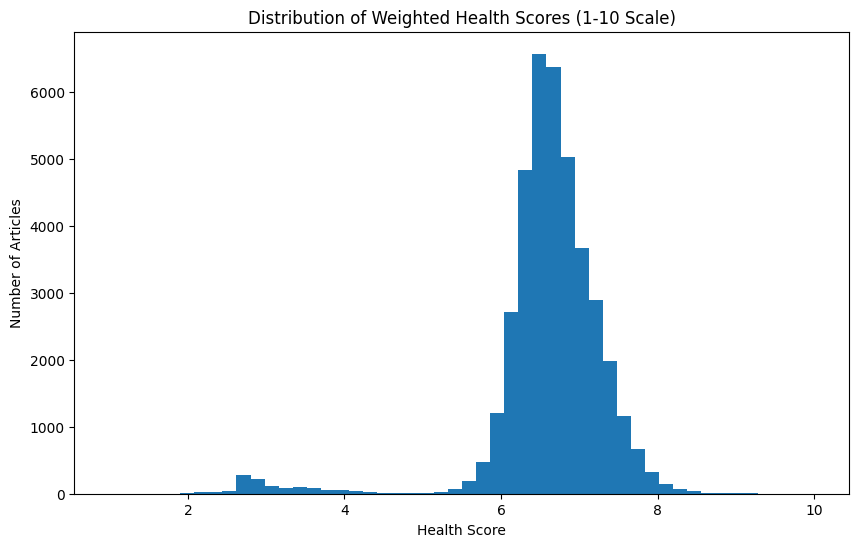

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(df_clean['health_score'], bins=50)
plt.title('Distribution of Weighted Health Scores (1-10 Scale)')
plt.xlabel('Health Score')
plt.ylabel('Number of Articles')
plt.show()

In [26]:
# Show some example articles and their scores
print("\nTop articles by health score:")
sample_results = df[['url', 'health_score']].sort_values('health_score', ascending=False).head()
print(sample_results.round(2))  # Round to 2 decimal places for cleaner output


Top articles by health score:
                                                     url  health_score
9365     http://mashable.com/2013/07/03/low-cost-iphone/         10.00
5370   http://mashable.com/2013/04/15/dove-ad-beauty-...          9.59
23237  http://mashable.com/2014/04/09/first-100-gilt-...          9.38
3145   http://mashable.com/2013/03/02/wealth-inequality/          9.27
24612  http://mashable.com/2014/05/03/joe-biden-comme...          9.20


In [27]:
df[score_features + ['health_score']]


,shares,num_hrefs,num_imgs,num_videos,global_sentiment_polarity,global_rate_positive_words,avg_positive_polarity,n_tokens_content,average_token_length,num_self_hrefs,health_score
0,593,4.0,1.0,0.0,0.092562,0.045662,0.378636,219.0,4.680365,2.0,6.322827
1,711,3.0,1.0,0.0,0.148948,0.043137,0.286915,255.0,4.913725,1.0,6.264997
2,1500,3.0,1.0,0.0,0.323333,0.056872,0.495833,211.0,4.393365,1.0,6.661738
3,1200,9.0,1.0,0.0,0.100705,0.041431,0.385965,531.0,4.404896,0.0,6.419256
4,505,19.0,20.0,0.0,0.281003,0.074627,0.411127,1072.0,4.682836,19.0,7.686162
...,...,...,...,...,...,...,...,...,...,...,...
39639,1800,9.0,1.0,1.0,0.141964,0.037572,0.333791,346.0,4.523121,7.0,6.722423
39640,1900,9.0,3.0,48.0,0.194249,0.039634,0.374825,328.0,4.405488,7.0,7.686468
39641,1900,24.0,12.0,1.0,0.024609,0.033937,0.307273,442.0,5.076923,1.0,7.032296
39642,1100,10.0,1.0,0.0,-0.008066,0.020528,0.236851,682.0,4.975073,1.0,6.112235


In [28]:
# Put the health score in the original dataframe
df['health_score'] = df['health_score'].round(2)
df.head()


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,health_score
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,6.32
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,6.26
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,6.66
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,6.42
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,7.69


### Inspect the relationship between features and article success